### Step #0. Fire the system

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import sklearn
from sklearn.metrics import mean_squared_error

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

Using TensorFlow backend.


### Step #1. Read data

In [2]:
#Download and Import CSV file into a pandas dataframe
url = 'https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv'
dataset  = pd.read_csv(url, error_bad_lines=False)

# Select features (columns) to be involved intro evaluation, training and predictions
cols = ['Row_ID','Accurate_Episode_Date','Age_Group','Reporting_PHU']
dataset = dataset[cols]

# drop rows with no row_id, date or age row value
dataset = dataset[dataset.Accurate_Episode_Date.notnull()]
dataset = dataset[dataset.Row_ID.notnull()]
dataset = dataset[dataset.Age_Group.notnull()]
dataset = dataset[dataset.Age_Group !='UNKNOWN']

print('Dataset shape == {}'.format(dataset.shape))
print('Featured selected: {}'.format(dataset.keys()))

Dataset shape == (50523, 4)
Featured selected: Index(['Row_ID', 'Accurate_Episode_Date', 'Age_Group', 'Reporting_PHU'], dtype='object')


### Step #2. Data pre-processing

Recoding dataset and convert data to matrix shape format.

In [3]:
#Recoding "Age_Group" feature to "0_to_60_years" and "60_years_and_over"
def age_regroup (row):
   if row['Age_Group'] == '<20' :
      return '0_to_60_years'
   if row['Age_Group'] == '20s' :
      return '0_to_60_years'
   if row['Age_Group'] == '30s' :
      return '0_to_60_years'
   if row['Age_Group'] == '40s' :
      return '0_to_60_years'
   if row['Age_Group'] == '50s' :
      return '0_to_60_years'
   if row['Age_Group'] == '60s' :
      return '60_years_and_over'
   if row['Age_Group'] == '70s' :
      return '60_years_and_over'
   if row['Age_Group'] == '80s' :
      return '60_years_and_over'
   if row['Age_Group'] == '90s' :
      return '60_years_and_over'
     
dataset['Age_Groups'] = dataset.apply (lambda row: age_regroup(row), axis=1)


In [4]:
#Recoding "Reporting_PHU" feature to "GTA_PHUs" and "Other_PHUs"
def phu_regroup (row):
   if row['Reporting_PHU'] == 'Toronto Public Health' :
      return 'GTA_PHUs'
   if row['Reporting_PHU'] == 'York Region Public Health Services' :
      return 'GTA_PHUs'
   if row['Reporting_PHU'] == 'Peel Public Health' :
      return 'GTA_PHUs'
   if row['Reporting_PHU'] == 'Halton Region Health Department' :
      return 'GTA_PHUs'    
   if row['Reporting_PHU'] == 'Durham Region Health Department' :
      return 'GTA_PHUs'       
   else:
      return 'Other_PHUs'
    
dataset['PHU_Groups'] = dataset.apply (lambda row: phu_regroup(row), axis=1)

In [5]:
#Aggregate confirmed cases for each day in Ontario ignoring all features
Column_1= dataset.groupby('Accurate_Episode_Date').count()['Row_ID'].reset_index()
Column_1= Column_1.rename(columns={'Row_ID':'Ontario'})  

In [6]:
#Aggregate confirmed cases for each day for cases in GTA_PHUs for 0 to 60 years age group.
Column_2= dataset[(dataset.PHU_Groups == 'GTA_PHUs') & (dataset.Age_Groups == '0_to_60_years')]
Column_2= Column_2.groupby('Accurate_Episode_Date').count()['Row_ID'].reset_index()
Column_2= Column_2.rename(columns={'Row_ID':'GTA_PHUs_Under_60'}) 

In [7]:
#Aggregate confirmed cases for each day for cases in GTA_PHUs for "60_years_and_over" age group.
Column_3= dataset[(dataset.PHU_Groups == 'GTA_PHUs') & (dataset.Age_Groups == '60_years_and_over')]
Column_3= Column_3.groupby('Accurate_Episode_Date').count()['Row_ID'].reset_index()
Column_3= Column_3.rename(columns={'Row_ID':'GTA_PHUs_60_and_Over'}) 


In [8]:
#Aggregate confirmed cases for each day for cases in Other_PHUs for 0 to 60 years age group.
Column_4= dataset[(dataset.PHU_Groups == 'Other_PHUs') & (dataset.Age_Groups == '0_to_60_years')]
Column_4= Column_4.groupby('Accurate_Episode_Date').count()['Row_ID'].reset_index()
Column_4= Column_4.rename(columns={'Row_ID':'Other_PHUs_Under_60'}) 

In [9]:
#Aggregate confirmed cases for each day for cases in Other_PHUs for "60_years_and_over" age group.
Column_5= dataset[(dataset.PHU_Groups == 'Other_PHUs') & (dataset.Age_Groups == '60_years_and_over')]
Column_5= Column_5.groupby('Accurate_Episode_Date').count()['Row_ID'].reset_index()
Column_5= Column_5.rename(columns={'Row_ID':'Other_PHUs_60_and_Over'}) 

In [10]:
#Left join all the columns with column 1 to make sure each feature has a value for any given day in the range.
dataset_base = pd.merge(Column_1,Column_2,on='Accurate_Episode_Date',how='left')
dataset_base = pd.merge(dataset_base,Column_3,on='Accurate_Episode_Date',how='left')
dataset_base = pd.merge(dataset_base,Column_4,on='Accurate_Episode_Date',how='left')
dataset_base = pd.merge(dataset_base,Column_5,on='Accurate_Episode_Date',how='left')
dataset_base = dataset_base.fillna(0)
dataset_base['Accurate_Episode_Date'] =  pd.to_datetime(dataset_base['Accurate_Episode_Date'], format='%Y-%m-%d')
dataset_base = dataset_base.set_index('Accurate_Episode_Date')
dataset_base.shape

(239, 5)

In [11]:
#Convert values to float. This is important in numerical computations and transformations.
dataset_base.iloc[:, 0:] = dataset_base.iloc[:, 0:].astype(float)
dataset_base.shape

(239, 5)

In [12]:
#Drop the last two days as usually these values get updated afterward. 
#Also use the data starting from 2020-02-19 which the data is reported on the daily bases.
dataset_base = dataset_base.iloc[17:-2, :]
dataset_base.head()

,Ontario,GTA_PHUs_Under_60,GTA_PHUs_60_and_Over,Other_PHUs_Under_60,Other_PHUs_60_and_Over
Accurate_Episode_Date,,,,,
2020-02-19,1.0,1.0,0.0,0.0,0.0
2020-02-20,5.0,0.0,2.0,2.0,1.0
2020-02-21,1.0,0.0,1.0,0.0,0.0
2020-02-22,4.0,1.0,2.0,1.0,0.0
2020-02-23,4.0,0.0,1.0,1.0,2.0


##### Step #2-1. Splitting data to training and test. 
7 days from the tail of the dataset won't be used for training and will be used in testing.

In [13]:
#Store these 7 days into dataset_base_test dataframe.
dataset_base_test = dataset_base.iloc[-7:, :]
dataset_base_test

,Ontario,GTA_PHUs_Under_60,GTA_PHUs_60_and_Over,Other_PHUs_Under_60,Other_PHUs_60_and_Over
Accurate_Episode_Date,,,,,
2020-09-19,306.0,193.0,21.0,84.0,8.0
2020-09-20,252.0,147.0,28.0,64.0,13.0
2020-09-21,379.0,218.0,22.0,126.0,13.0
2020-09-22,433.0,263.0,40.0,114.0,16.0
2020-09-23,410.0,263.0,46.0,92.0,9.0
2020-09-24,307.0,193.0,25.0,74.0,15.0
2020-09-25,169.0,119.0,29.0,16.0,5.0


In [14]:
#Remove these 7 days from the training set
dataset_base = dataset_base.iloc[:-7, :]
dataset_base.shape

(213, 5)

In [15]:
# Extract dates (will be used in visualization)
datelist = dataset_base.index.tolist()
print('All timestamps == {}'.format(len(datelist)))

All timestamps == 213


### Step #3. Create a model & Train & Visualize it

5 separate models (LSTM based Neural Network) will be created and the result of them will be compared.

In [16]:
# Import Libraries for Feature Scaling from sklearn
from sklearn.preprocessing import MinMaxScaler

In [17]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

#### Step #3-1. Ontario Model
Traning and Test sets for all Ontario without considering any of the features (Base Model)

##### Step #3-1-1. Final adjustments to data and create the model

In [18]:
#Aggregate confirmed cases for each day ignoring all features
ontario_train= dataset_base.iloc[:, 0:1].values
print('Shape of ontario_train set == {}.'.format(ontario_train.shape))

Shape of ontario_train set == (213, 1).


In [19]:
# Feature Scaling
sc_ontario = MinMaxScaler(feature_range = (0, 1))
ontario_train_scaled = sc_ontario.fit_transform(ontario_train)
ontario_train_scaled.shape


(213, 1)

In [20]:
# Creating a data structure with 14 timestamps and 1 output
x_ontario_train = []
y_ontario_train = []

n_future = 7   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(ontario_train_scaled) - n_future +1):
    x_ontario_train.append(ontario_train_scaled[i - n_past:i, 0:ontario_train_scaled.shape[1]])
    y_ontario_train.append(ontario_train_scaled[i + n_future - 1:i + n_future, 0])

x_ontario_train, y_ontario_train = np.array(x_ontario_train), np.array(y_ontario_train)

print('x_ontario_train shape == {}.'.format(x_ontario_train.shape))
print('y_ontario_train shape == {}.'.format(y_ontario_train.shape))

x_ontario_train shape == (193, 14, 1).
y_ontario_train shape == (193, 1).


In [21]:
# Initializing the Neural Network based on LSTM
model_Ontario = Sequential()
model_Ontario.add(LSTM(units=256, activation='tanh', return_sequences=True, input_shape=(x_ontario_train.shape[1], 1)))
model_Ontario.add(Dropout(0.2))
model_Ontario.add(LSTM(units=128, return_sequences=True))
model_Ontario.add(Dropout(0.2))
model_Ontario.add(LSTM(units=128, return_sequences=False))
model_Ontario.add(Dropout(0.2))
model_Ontario.add(Dense(units = 1))
model_Ontario.compile(optimizer = 'adam', loss = 'mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


##### Step #3-1-2. Start model training

In [22]:
model_Ontario.fit(x_ontario_train, y_ontario_train, epochs = 50, batch_size = 16)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
193/193 [==============================] - 7s 39ms/step - loss: 0.0623
Epoch 2/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0288
Epoch 3/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0284
Epoch 4/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0262
Epoch 5/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0238
Epoch 6/50
193/193 [==============================] - 3s 14ms/step - loss: 0.0229
Epoch 7/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0274
Epoch 8/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0274
Epoch 9/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0263
Epoch 10/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0218
Epoch 11/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0222
Epoch 12/50
193/193 [==============================] - 3

##### Step #3-1-3. Make predictions for future dates and also training dates (for illustration)

In [23]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist[-1], periods=n_future+1,freq='1d').tolist()
datelist_future = datelist_future[1:]
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())  

In [24]:
# Perform predictions
predictions_future_ontario = model_Ontario.predict(x_ontario_train[-n_future:])

predictions_train_ontario = model_Ontario.predict(x_ontario_train)


In [25]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future_ontario = sc_ontario.inverse_transform(predictions_future_ontario)
y_pred_train_ontario = sc_ontario.inverse_transform(predictions_train_ontario)

PREDICTIONS_FUTURE_ontario = pd.DataFrame(y_pred_future_ontario, columns=['result']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN_ontario = pd.DataFrame(y_pred_train_ontario, columns=['result']).set_index(pd.Series(datelist[n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN_ontario.index = PREDICTION_TRAIN_ontario.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN_ontario.head()

,result
2020-03-10,92.429909
2020-03-11,96.473915
2020-03-12,100.508568
2020-03-13,106.909378
2020-03-14,113.539543


##### Step #3-1-4. Visualize the Predictions

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


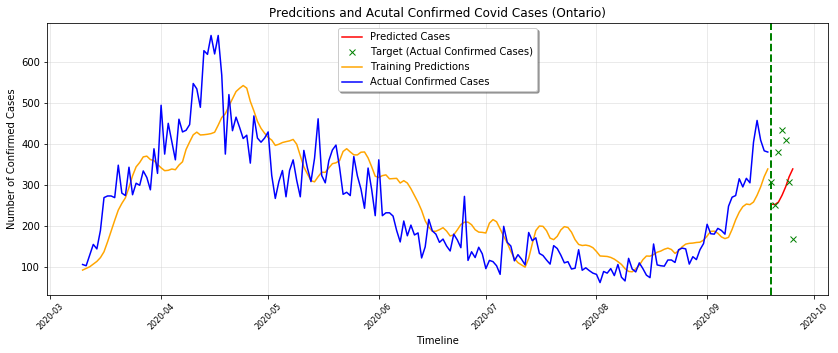

In [26]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-03-10'

plt.plot(PREDICTIONS_FUTURE_ontario.index, PREDICTIONS_FUTURE_ontario['result'], color='r', label='Predicted Cases')
plt.plot(dataset_base_test.index,dataset_base_test['Ontario'],'x', color='g', label='Target (Actual Confirmed Cases)')
plt.plot(PREDICTION_TRAIN_ontario.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_ontario.loc[START_DATE_FOR_PLOTTING:]['result'], color='orange', label='Training Predictions')
plt.plot(dataset_base.loc[START_DATE_FOR_PLOTTING:].index, dataset_base.loc[START_DATE_FOR_PLOTTING:]['Ontario'], color='b', label='Actual Confirmed Cases')

plt.axvline(x = min(PREDICTIONS_FUTURE_ontario.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Confirmed Covid Cases (Ontario)', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Number of Confirmed Cases', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

##### Step #3-1-5. Testing Accuracy of the Predictions

In [27]:
# Calcualte root mean square error between targets and predicted values.
targets_ontario = dataset_base_test.Ontario.tolist()
predicted_ontario = PREDICTIONS_FUTURE_ontario.result.tolist()

rmse_ontario = np.sqrt(mean_squared_error(targets_ontario, predicted_ontario))

print('Root mean square error between targets and predicted values == {}'.format(rmse_ontario))

Root mean square error between targets and predicted values == 109.95497878552948


##### Step #3-1-6. Predictions

In [28]:
# Present the 7 predicted days and the mean, median and stdev for them
print('Predicted values Ontario == {}'.format(predicted_ontario))
print('Mean of predicted values Ontario == {}'.format(np.mean(np.array(predicted_ontario))))
print('Median of predicted values Ontario == {}'.format(np.median(np.array(predicted_ontario))))
print('Standard Deviation of predicted values Ontario == {}'.format(np.std(np.array(predicted_ontario))))

Predicted values Ontario == [253.28668212890625, 251.9102020263672, 258.2413635253906, 274.7395935058594, 295.0545959472656, 320.09332275390625, 338.8207702636719]
Mean of predicted values Ontario == 284.5923614501953
Median of predicted values Ontario == 274.7395935058594
Standard Deviation of predicted values Ontario == 31.960060246614745


#### Step #3-2. GTA_PHUs_Under_60 Model
Traning and Test sets for GTA_PHUs_Under_60.

##### Step #3-2-1. Final adjustments to data and create the model

In [29]:
#Aggregate confirmed cases for each day ignoring all features
GTA_PHUs_Under_60_train= dataset_base.iloc[:, 1:2].values
print('Shape of GTA_PHUs_Under_60_train set == {}.'.format(GTA_PHUs_Under_60_train.shape))

Shape of GTA_PHUs_Under_60_train set == (213, 1).


In [30]:
# Feature Scaling
sc_GTA_PHUs_Under_60 = MinMaxScaler(feature_range = (0, 1))
GTA_PHUs_Under_60_train_scaled = sc_GTA_PHUs_Under_60.fit_transform(GTA_PHUs_Under_60_train)
GTA_PHUs_Under_60_train_scaled.shape

(213, 1)

In [31]:
# Creating a data structure with 14 timestamps and 1 output
x_GTA_PHUs_Under_60_train = []
y_GTA_PHUs_Under_60_train = []

n_future = 7   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(GTA_PHUs_Under_60_train_scaled) - n_future +1):
    x_GTA_PHUs_Under_60_train.append(GTA_PHUs_Under_60_train_scaled[i - n_past:i, 0:GTA_PHUs_Under_60_train_scaled.shape[1]])
    y_GTA_PHUs_Under_60_train.append(GTA_PHUs_Under_60_train_scaled[i + n_future - 1:i + n_future, 0])

x_GTA_PHUs_Under_60_train, y_GTA_PHUs_Under_60_train = np.array(x_GTA_PHUs_Under_60_train), np.array(y_GTA_PHUs_Under_60_train)

print('x_GTA_PHUs_Under_60_train shape == {}.'.format(x_GTA_PHUs_Under_60_train.shape))
print('y_GTA_PHUs_Under_60_train shape == {}.'.format(y_GTA_PHUs_Under_60_train.shape))

x_GTA_PHUs_Under_60_train shape == (193, 14, 1).
y_GTA_PHUs_Under_60_train shape == (193, 1).


In [32]:
# Initializing the Neural Network based on LSTM
model_GTA_PHUs_Under_60 = Sequential()
model_GTA_PHUs_Under_60.add(LSTM(units=256, activation='tanh', return_sequences=True, input_shape=(x_GTA_PHUs_Under_60_train.shape[1], 1)))
model_GTA_PHUs_Under_60.add(Dropout(0.2))
model_GTA_PHUs_Under_60.add(LSTM(units=128, return_sequences=True))
model_GTA_PHUs_Under_60.add(Dropout(0.2))
model_GTA_PHUs_Under_60.add(LSTM(units=128, return_sequences=False))
model_GTA_PHUs_Under_60.add(Dropout(0.2))
model_GTA_PHUs_Under_60.add(Dense(units = 1))
model_GTA_PHUs_Under_60.compile(optimizer = 'adam', loss = 'mean_squared_error')

##### Step #3-2-2. Start model training

In [33]:
model_GTA_PHUs_Under_60.fit(x_GTA_PHUs_Under_60_train, y_GTA_PHUs_Under_60_train, epochs = 50, batch_size = 16)

Epoch 1/50
193/193 [==============================] - 8s 43ms/step - loss: 0.0933
Epoch 2/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0384
Epoch 3/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0325
Epoch 4/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0280
Epoch 5/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0305
Epoch 6/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0282
Epoch 7/50
193/193 [==============================] - 3s 14ms/step - loss: 0.0285
Epoch 8/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0282
Epoch 9/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0272
Epoch 10/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0263
Epoch 11/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0258
Epoch 12/50
193/193 [==============================] - 2s 13ms/step - loss: 0.0302
Epoch 13/50
193/193 

##### Step #3-2-3. Make predictions for future dates and also training dates (for illustration)

In [34]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist[-1], periods=n_future+1,freq='1d').tolist()
datelist_future = datelist_future[1:]
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())  

In [35]:
# Perform predictions
predictions_future_GTA_PHUs_Under_60 = model_GTA_PHUs_Under_60.predict(x_GTA_PHUs_Under_60_train[-n_future:])

predictions_train_GTA_PHUs_Under_60 = model_GTA_PHUs_Under_60.predict(x_GTA_PHUs_Under_60_train)

In [36]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future_GTA_PHUs_Under_60 = sc_GTA_PHUs_Under_60.inverse_transform(predictions_future_GTA_PHUs_Under_60)
y_pred_train_GTA_PHUs_Under_60 = sc_GTA_PHUs_Under_60.inverse_transform(predictions_train_GTA_PHUs_Under_60)

PREDICTIONS_FUTURE_GTA_PHUs_Under_60 = pd.DataFrame(y_pred_future_GTA_PHUs_Under_60, columns=['result']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN_GTA_PHUs_Under_60 = pd.DataFrame(y_pred_train_GTA_PHUs_Under_60, columns=['result']).set_index(pd.Series(datelist[n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN_GTA_PHUs_Under_60.index = PREDICTION_TRAIN_GTA_PHUs_Under_60.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN_GTA_PHUs_Under_60.head()

,result
2020-03-10,28.553852
2020-03-11,30.467903
2020-03-12,32.152172
2020-03-13,35.706413
2020-03-14,40.595928


##### Step #3-2-4. Visualize the Predictions

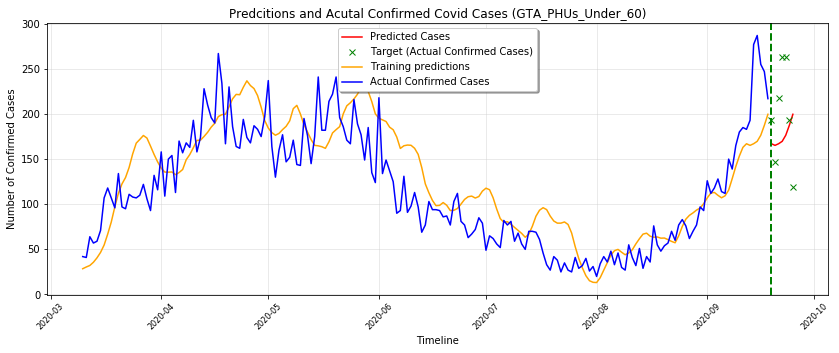

In [37]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-03-10'

plt.plot(PREDICTIONS_FUTURE_GTA_PHUs_Under_60.index, PREDICTIONS_FUTURE_GTA_PHUs_Under_60['result'], color='r', label='Predicted Cases')
plt.plot(dataset_base_test.index,dataset_base_test['GTA_PHUs_Under_60'],'x', color='g', label='Target (Actual Confirmed Cases)')
plt.plot(PREDICTION_TRAIN_GTA_PHUs_Under_60.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_GTA_PHUs_Under_60.loc[START_DATE_FOR_PLOTTING:]['result'], color='orange', label='Training predictions')
plt.plot(dataset_base.loc[START_DATE_FOR_PLOTTING:].index, dataset_base.loc[START_DATE_FOR_PLOTTING:]['GTA_PHUs_Under_60'], color='b', label='Actual Confirmed Cases')

plt.axvline(x = min(PREDICTIONS_FUTURE_GTA_PHUs_Under_60.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Confirmed Covid Cases (GTA_PHUs_Under_60)', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Number of Confirmed Cases', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

##### Step #3-2-5. Testing Accuracy of the Predictions

In [38]:
# Calcualte root mean square error between targets and predicted values.
targets_GTA_PHUs_Under_60 = dataset_base_test.GTA_PHUs_Under_60.tolist()
predicted_GTA_PHUs_Under_60 = PREDICTIONS_FUTURE_GTA_PHUs_Under_60.result.tolist()

rmse_GTA_PHUs_Under_60 = np.sqrt(mean_squared_error(targets_GTA_PHUs_Under_60, predicted_GTA_PHUs_Under_60))

print('Root mean square error between targets and predicted values == {}'.format(rmse_GTA_PHUs_Under_60))

Root mean square error between targets and predicted values == 61.341018777443544


##### Step #3-2-6. Predictions

In [39]:
# Present the 7 predicted days and the mean, median and stdev for them
print('Predicted values GTA_PHUs_Under_60 == {}'.format(predicted_GTA_PHUs_Under_60))
print('Mean of predicted values GTA_PHUs_Under_60 == {}'.format(np.mean(np.array(predicted_GTA_PHUs_Under_60))))
print('Median of predicted values GTA_PHUs_Under_60 == {}'.format(np.median(np.array(predicted_GTA_PHUs_Under_60))))
print('Standard Deviation of predicted values GTA_PHUs_Under_60 == {}'.format(np.std(np.array(predicted_GTA_PHUs_Under_60))))

Predicted values GTA_PHUs_Under_60 == [167.02134704589844, 165.23634338378906, 167.05975341796875, 169.70701599121094, 176.44662475585938, 187.3855438232422, 199.6851348876953]
Mean of predicted values GTA_PHUs_Under_60 == 176.07739475795202
Median of predicted values GTA_PHUs_Under_60 == 169.70701599121094
Standard Deviation of predicted values GTA_PHUs_Under_60 == 11.992711692263178


#### Step #3-3. GTA_PHUs_60_and_Over Model
Traning and Test sets for GTA_PHUs_60_and_Over.

##### Step #3-3-1. Final adjustments to data and create the model

In [40]:
#Aggregate confirmed cases for each day ignoring all features
GTA_PHUs_60_and_Over_train= dataset_base.iloc[:, 2:3].values
print('Shape of GTA_PHUs_60_and_Over_train set == {}.'.format(GTA_PHUs_60_and_Over_train.shape))

Shape of GTA_PHUs_60_and_Over_train set == (213, 1).


In [41]:
# Feature Scaling
sc_GTA_PHUs_60_and_Over = MinMaxScaler(feature_range = (0, 1))
GTA_PHUs_60_and_Over_train_scaled = sc_GTA_PHUs_60_and_Over.fit_transform(GTA_PHUs_60_and_Over_train)
GTA_PHUs_60_and_Over_train_scaled.shape

(213, 1)

In [42]:
# Creating a data structure with 14 timestamps and 1 output
x_GTA_PHUs_60_and_Over_train = []
y_GTA_PHUs_60_and_Over_train = []

n_future = 7   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(GTA_PHUs_60_and_Over_train_scaled) - n_future +1):
    x_GTA_PHUs_60_and_Over_train.append(GTA_PHUs_60_and_Over_train_scaled[i - n_past:i, 0:GTA_PHUs_60_and_Over_train_scaled.shape[1]])
    y_GTA_PHUs_60_and_Over_train.append(GTA_PHUs_60_and_Over_train_scaled[i + n_future - 1:i + n_future, 0])

x_GTA_PHUs_60_and_Over_train, y_GTA_PHUs_60_and_Over_train = np.array(x_GTA_PHUs_60_and_Over_train), np.array(y_GTA_PHUs_60_and_Over_train)

print('x_GTA_PHUs_60_and_Over_train shape == {}.'.format(x_GTA_PHUs_60_and_Over_train.shape))
print('y_GTA_PHUs_60_and_Over_train shape == {}.'.format(y_GTA_PHUs_60_and_Over_train.shape))

x_GTA_PHUs_60_and_Over_train shape == (193, 14, 1).
y_GTA_PHUs_60_and_Over_train shape == (193, 1).


In [43]:
# Initializing the Neural Network based on LSTM
model_GTA_PHUs_60_and_Over = Sequential()
model_GTA_PHUs_60_and_Over.add(LSTM(units=256, activation='tanh', return_sequences=True, input_shape=(x_GTA_PHUs_60_and_Over_train.shape[1], 1)))
model_GTA_PHUs_60_and_Over.add(Dropout(0.2))
model_GTA_PHUs_60_and_Over.add(LSTM(units=128, return_sequences=True))
model_GTA_PHUs_60_and_Over.add(Dropout(0.2))
model_GTA_PHUs_60_and_Over.add(LSTM(units=128, return_sequences=False))
model_GTA_PHUs_60_and_Over.add(Dropout(0.2))
model_GTA_PHUs_60_and_Over.add(Dense(units = 1))
model_GTA_PHUs_60_and_Over.compile(optimizer = 'adam', loss = 'mean_squared_error')

##### Step #3-3-2. Start model training

In [44]:
model_GTA_PHUs_60_and_Over.fit(x_GTA_PHUs_60_and_Over_train, y_GTA_PHUs_60_and_Over_train, epochs = 50, batch_size = 16)

Epoch 1/50
193/193 [==============================] - 8s 40ms/step - loss: 0.0254
Epoch 2/50
193/193 [==============================] - 3s 14ms/step - loss: 0.0240
Epoch 3/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0194
Epoch 4/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0165
Epoch 5/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0187
Epoch 6/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0170
Epoch 7/50
193/193 [==============================] - 2s 12ms/step - loss: 0.0215
Epoch 8/50
193/193 [==============================] - 2s 11ms/step - loss: 0.0157
Epoch 9/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0149
Epoch 10/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0191
Epoch 11/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0177
Epoch 12/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0157
Epoch 13/50
193/1

##### Step #3-3-3. Make predictions for future dates and also training dates (for illustration)

In [45]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist[-1], periods=n_future+1,freq='1d').tolist()
datelist_future = datelist_future[1:]
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())  

In [46]:
# Perform predictions
predictions_future_GTA_PHUs_60_and_Over = model_GTA_PHUs_60_and_Over.predict(x_GTA_PHUs_60_and_Over_train[-n_future:])

predictions_train_GTA_PHUs_60_and_Over = model_GTA_PHUs_60_and_Over.predict(x_GTA_PHUs_60_and_Over_train)

In [47]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future_GTA_PHUs_60_and_Over = sc_GTA_PHUs_60_and_Over.inverse_transform(predictions_future_GTA_PHUs_60_and_Over)
y_pred_train_GTA_PHUs_60_and_Over = sc_GTA_PHUs_60_and_Over.inverse_transform(predictions_train_GTA_PHUs_60_and_Over)

PREDICTIONS_FUTURE_GTA_PHUs_60_and_Over = pd.DataFrame(y_pred_future_GTA_PHUs_60_and_Over, columns=['result']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN_GTA_PHUs_60_and_Over = pd.DataFrame(y_pred_train_GTA_PHUs_60_and_Over, columns=['result']).set_index(pd.Series(datelist[n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN_GTA_PHUs_60_and_Over.index = PREDICTION_TRAIN_GTA_PHUs_60_and_Over.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN_GTA_PHUs_60_and_Over.head()

,result
2020-03-10,23.199821
2020-03-11,24.970278
2020-03-12,26.648933
2020-03-13,27.580036
2020-03-14,28.123684


##### Step #3-3-4. Visualize the Predictions

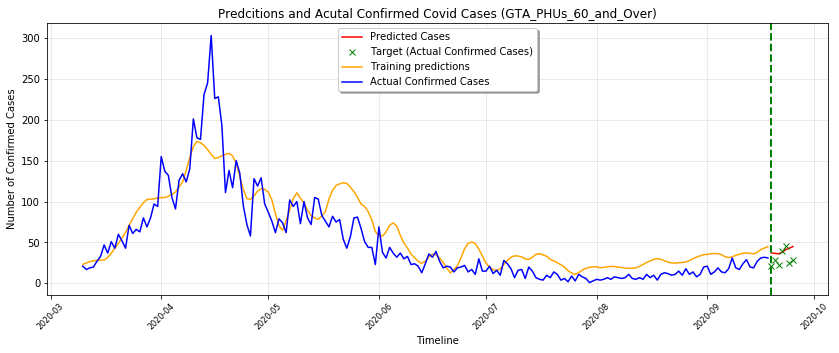

In [48]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-03-10'

plt.plot(PREDICTIONS_FUTURE_GTA_PHUs_60_and_Over.index, PREDICTIONS_FUTURE_GTA_PHUs_60_and_Over['result'], color='r', label='Predicted Cases')
plt.plot(dataset_base_test.index,dataset_base_test['GTA_PHUs_60_and_Over'],'x', color='g', label='Target (Actual Confirmed Cases)')
plt.plot(PREDICTION_TRAIN_GTA_PHUs_60_and_Over.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_GTA_PHUs_60_and_Over.loc[START_DATE_FOR_PLOTTING:]['result'], color='orange', label='Training predictions')
plt.plot(dataset_base.loc[START_DATE_FOR_PLOTTING:].index, dataset_base.loc[START_DATE_FOR_PLOTTING:]['GTA_PHUs_60_and_Over'], color='b', label='Actual Confirmed Cases')

plt.axvline(x = min(PREDICTIONS_FUTURE_GTA_PHUs_60_and_Over.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Confirmed Covid Cases (GTA_PHUs_60_and_Over)', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Number of Confirmed Cases', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

##### Step #3-3-5. Testing Accuracy of the Predictions

In [49]:
# Calcualte root mean square error between targets and predicted values.
targets_GTA_PHUs_60_and_Over = dataset_base_test.GTA_PHUs_60_and_Over.tolist()
predicted_GTA_PHUs_60_and_Over = PREDICTIONS_FUTURE_GTA_PHUs_60_and_Over.result.tolist()

rmse_GTA_PHUs_60_and_Over = np.sqrt(mean_squared_error(targets_GTA_PHUs_60_and_Over, predicted_GTA_PHUs_60_and_Over))

print('Root mean square error between targets and predicted values == {}'.format(rmse_GTA_PHUs_60_and_Over))

Root mean square error between targets and predicted values == 12.801167856952466


##### Step #3-3-6. Predictions

In [50]:
# Present the 7 predicted days and the mean, median and stdev for them
print('Predicted values GTA_PHUs_60_and_Over == {}'.format(predicted_GTA_PHUs_60_and_Over))
print('Mean of predicted values GTA_PHUs_60_and_Over == {}'.format(np.mean(np.array(predicted_GTA_PHUs_60_and_Over))))
print('Median of predicted values GTA_PHUs_60_and_Over == {}'.format(np.median(np.array(predicted_GTA_PHUs_60_and_Over))))
print('Standard Deviation of predicted values GTA_PHUs_60_and_Over == {}'.format(np.std(np.array(predicted_GTA_PHUs_60_and_Over))))

Predicted values GTA_PHUs_60_and_Over == [37.204708099365234, 36.651771545410156, 36.155479431152344, 38.04682922363281, 41.2951545715332, 43.086669921875, 45.0058708190918]
Mean of predicted values GTA_PHUs_60_and_Over == 39.63521194458008
Median of predicted values GTA_PHUs_60_and_Over == 38.04682922363281
Standard Deviation of predicted values GTA_PHUs_60_and_Over == 3.228261629298201


#### Step #3-4. Other_PHUs_Under_60 Model
Traning and Test sets for Other_PHUs_Under_60.

##### Step #3-4-1. Final adjustments to data and create the model

In [51]:
#Aggregate confirmed cases for each day ignoring all features
Other_PHUs_Under_60_train= dataset_base.iloc[:, 3:4].values
print('Shape of Other_PHUs_Under_60_train set == {}.'.format(Other_PHUs_Under_60_train.shape))

Shape of Other_PHUs_Under_60_train set == (213, 1).


In [52]:
# Feature Scaling
sc_Other_PHUs_Under_60 = MinMaxScaler(feature_range = (0, 1))
Other_PHUs_Under_60_train_scaled = sc_Other_PHUs_Under_60.fit_transform(Other_PHUs_Under_60_train)
Other_PHUs_Under_60_train_scaled.shape

(213, 1)

In [53]:
# Creating a data structure with 14 timestamps and 1 output
x_Other_PHUs_Under_60_train = []
y_Other_PHUs_Under_60_train = []

n_future = 7   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(Other_PHUs_Under_60_train_scaled) - n_future +1):
    x_Other_PHUs_Under_60_train.append(Other_PHUs_Under_60_train_scaled[i - n_past:i, 0:Other_PHUs_Under_60_train_scaled.shape[1]])
    y_Other_PHUs_Under_60_train.append(Other_PHUs_Under_60_train_scaled[i + n_future - 1:i + n_future, 0])

x_Other_PHUs_Under_60_train, y_Other_PHUs_Under_60_train = np.array(x_Other_PHUs_Under_60_train), np.array(y_Other_PHUs_Under_60_train)

print('x_Other_PHUs_Under_60_train shape == {}.'.format(x_Other_PHUs_Under_60_train.shape))
print('y_Other_PHUs_Under_60_train shape == {}.'.format(y_Other_PHUs_Under_60_train.shape))

x_Other_PHUs_Under_60_train shape == (193, 14, 1).
y_Other_PHUs_Under_60_train shape == (193, 1).


In [54]:
# Initializing the Neural Network based on LSTM
model_Other_PHUs_Under_60 = Sequential()
model_Other_PHUs_Under_60.add(LSTM(units=256, activation='tanh', return_sequences=True, input_shape=(x_Other_PHUs_Under_60_train.shape[1], 1)))
model_Other_PHUs_Under_60.add(Dropout(0.2))
model_Other_PHUs_Under_60.add(LSTM(units=128, return_sequences=True))
model_Other_PHUs_Under_60.add(Dropout(0.2))
model_Other_PHUs_Under_60.add(LSTM(units=128, return_sequences=False))
model_Other_PHUs_Under_60.add(Dropout(0.2))
model_Other_PHUs_Under_60.add(Dense(units = 1))
model_Other_PHUs_Under_60.compile(optimizer = 'adam', loss = 'mean_squared_error')

##### Step #3-4-2. Start model training

In [55]:
model_Other_PHUs_Under_60.fit(x_Other_PHUs_Under_60_train, y_Other_PHUs_Under_60_train, epochs = 50, batch_size = 16)

Epoch 1/50
193/193 [==============================] - 8s 41ms/step - loss: 0.0495
Epoch 2/50
193/193 [==============================] - 2s 12ms/step - loss: 0.0259
Epoch 3/50
193/193 [==============================] - 2s 11ms/step - loss: 0.0228
Epoch 4/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0216
Epoch 5/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0218
Epoch 6/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0213
Epoch 7/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0206
Epoch 8/50
193/193 [==============================] - 3s 16ms/step - loss: 0.0215
Epoch 9/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0189
Epoch 10/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0222
Epoch 11/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0198
Epoch 12/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0219
Epoch 13/50
193/19

##### Step #3-4-3. Make predictions for future dates and also training dates (for illustration)

In [56]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist[-1], periods=n_future+1,freq='1d').tolist()
datelist_future = datelist_future[1:]
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())  

In [57]:
# Perform predictions
predictions_future_Other_PHUs_Under_60 = model_Other_PHUs_Under_60.predict(x_Other_PHUs_Under_60_train[-n_future:])

predictions_train_Other_PHUs_Under_60 = model_Other_PHUs_Under_60.predict(x_Other_PHUs_Under_60_train)

In [58]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future_Other_PHUs_Under_60 = sc_Other_PHUs_Under_60.inverse_transform(predictions_future_Other_PHUs_Under_60)
y_pred_train_Other_PHUs_Under_60 = sc_Other_PHUs_Under_60.inverse_transform(predictions_train_Other_PHUs_Under_60)

PREDICTIONS_FUTURE_Other_PHUs_Under_60 = pd.DataFrame(y_pred_future_Other_PHUs_Under_60, columns=['result']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN_Other_PHUs_Under_60 = pd.DataFrame(y_pred_train_Other_PHUs_Under_60, columns=['result']).set_index(pd.Series(datelist[n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN_Other_PHUs_Under_60.index = PREDICTION_TRAIN_Other_PHUs_Under_60.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN_Other_PHUs_Under_60.head()

,result
2020-03-10,33.311176
2020-03-11,32.929092
2020-03-12,33.364811
2020-03-13,34.043991
2020-03-14,34.688301


##### Step #3-4-4. Visualize the Predictions

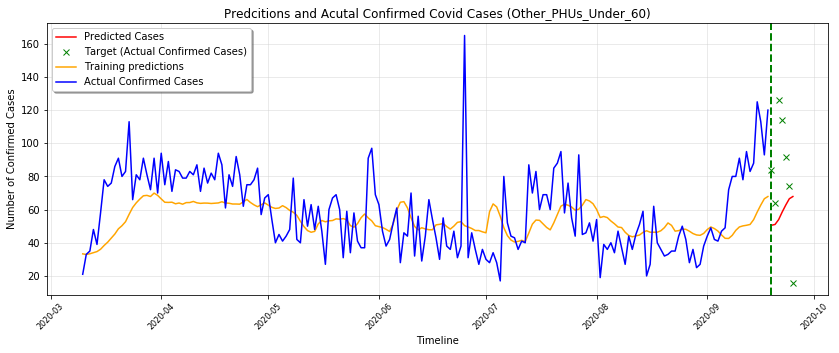

In [59]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-03-10'

plt.plot(PREDICTIONS_FUTURE_Other_PHUs_Under_60.index, PREDICTIONS_FUTURE_Other_PHUs_Under_60['result'], color='r', label='Predicted Cases')
plt.plot(dataset_base_test.index,dataset_base_test['Other_PHUs_Under_60'],'x', color='g', label='Target (Actual Confirmed Cases)')
plt.plot(PREDICTION_TRAIN_Other_PHUs_Under_60.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_Other_PHUs_Under_60.loc[START_DATE_FOR_PLOTTING:]['result'], color='orange', label='Training predictions')
plt.plot(dataset_base.loc[START_DATE_FOR_PLOTTING:].index, dataset_base.loc[START_DATE_FOR_PLOTTING:]['Other_PHUs_Under_60'], color='b', label='Actual Confirmed Cases')

plt.axvline(x = min(PREDICTIONS_FUTURE_Other_PHUs_Under_60.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Confirmed Covid Cases (Other_PHUs_Under_60)', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Number of Confirmed Cases', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

##### Step #3-4-5. Testing Accuracy of the Predictions

In [60]:
# Calcualte root mean square error between targets and predicted values.
targets_Other_PHUs_Under_60 = dataset_base_test.Other_PHUs_Under_60.tolist()
predicted_Other_PHUs_Under_60 = PREDICTIONS_FUTURE_Other_PHUs_Under_60.result.tolist()

rmse_Other_PHUs_Under_60 = np.sqrt(mean_squared_error(targets_Other_PHUs_Under_60, predicted_Other_PHUs_Under_60))

print('Root mean square error between targets and predicted values == {}'.format(rmse_Other_PHUs_Under_60))

Root mean square error between targets and predicted values == 43.358403203760446


##### Step #3-4-6. Predictions

In [61]:
# Present the 7 predicted days and the mean, median and stdev for them
print('Predicted values Other_PHUs_Under_60 == {}'.format(predicted_Other_PHUs_Under_60))
print('Mean of predicted values Other_PHUs_Under_60 == {}'.format(np.mean(np.array(predicted_Other_PHUs_Under_60))))
print('Median of predicted values Other_PHUs_Under_60 == {}'.format(np.median(np.array(predicted_Other_PHUs_Under_60))))
print('Standard Deviation of predicted values Other_PHUs_Under_60 == {}'.format(np.std(np.array(predicted_Other_PHUs_Under_60))))

Predicted values Other_PHUs_Under_60 == [50.54732894897461, 51.046443939208984, 53.94841384887695, 58.53435516357422, 62.74066925048828, 66.5465316772461, 67.89653778076172]
Mean of predicted values Other_PHUs_Under_60 == 58.751468658447266
Median of predicted values Other_PHUs_Under_60 == 58.53435516357422
Standard Deviation of predicted values Other_PHUs_Under_60 == 6.655833168330149


#### Step #3-5. Other_PHUs_60_and_Over Model
Traning and Test sets for Other_PHUs_60_and_Over.

##### Step #3-5-1. Final adjustments to data and create the model

In [62]:
#Aggregate confirmed cases for each day ignoring all features
Other_PHUs_60_and_Over_train= dataset_base.iloc[:, 4:5].values
print('Shape of Other_PHUs_60_and_Over_train set == {}.'.format(Other_PHUs_60_and_Over_train.shape))

Shape of Other_PHUs_60_and_Over_train set == (213, 1).


In [63]:
# Feature Scaling
sc_Other_PHUs_60_and_Over = MinMaxScaler(feature_range = (0, 1))
Other_PHUs_60_and_Over_train_scaled = sc_Other_PHUs_60_and_Over.fit_transform(Other_PHUs_60_and_Over_train)
Other_PHUs_60_and_Over_train_scaled.shape

(213, 1)

In [64]:
# Creating a data structure with 14 timestamps and 1 output
x_Other_PHUs_60_and_Over_train = []
y_Other_PHUs_60_and_Over_train = []

n_future = 7   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(Other_PHUs_60_and_Over_train_scaled) - n_future +1):
    x_Other_PHUs_60_and_Over_train.append(Other_PHUs_60_and_Over_train_scaled[i - n_past:i, 0:Other_PHUs_60_and_Over_train_scaled.shape[1]])
    y_Other_PHUs_60_and_Over_train.append(Other_PHUs_60_and_Over_train_scaled[i + n_future - 1:i + n_future, 0])

x_Other_PHUs_60_and_Over_train, y_Other_PHUs_60_and_Over_train = np.array(x_Other_PHUs_60_and_Over_train), np.array(y_Other_PHUs_60_and_Over_train)

print('x_Other_PHUs_60_and_Over_train shape == {}.'.format(x_Other_PHUs_60_and_Over_train.shape))
print('y_Other_PHUs_60_and_Over_train shape == {}.'.format(y_Other_PHUs_60_and_Over_train.shape))

x_Other_PHUs_60_and_Over_train shape == (193, 14, 1).
y_Other_PHUs_60_and_Over_train shape == (193, 1).


In [65]:
# Initializing the Neural Network based on LSTM
model_Other_PHUs_60_and_Over = Sequential()
model_Other_PHUs_60_and_Over.add(LSTM(units=256, activation='tanh', return_sequences=True, input_shape=(x_Other_PHUs_60_and_Over_train.shape[1], 1)))
model_Other_PHUs_60_and_Over.add(Dropout(0.2))
model_Other_PHUs_60_and_Over.add(LSTM(units=128, return_sequences=True))
model_Other_PHUs_60_and_Over.add(Dropout(0.2))
model_Other_PHUs_60_and_Over.add(LSTM(units=128, return_sequences=False))
model_Other_PHUs_60_and_Over.add(Dropout(0.2))
model_Other_PHUs_60_and_Over.add(Dense(units = 1))
model_Other_PHUs_60_and_Over.compile(optimizer = 'adam', loss = 'mean_squared_error')

##### Step #3-5-2. Start model training

In [66]:
model_Other_PHUs_60_and_Over.fit(x_Other_PHUs_60_and_Over_train, y_Other_PHUs_60_and_Over_train, epochs = 50, batch_size = 16)

Epoch 1/50
193/193 [==============================] - 9s 47ms/step - loss: 0.0307
Epoch 2/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0206
Epoch 3/50
193/193 [==============================] - 4s 19ms/step - loss: 0.0184
Epoch 4/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0243
Epoch 5/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0224
Epoch 6/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0184
Epoch 7/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0162
Epoch 8/50
193/193 [==============================] - 3s 14ms/step - loss: 0.0151
Epoch 9/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0168
Epoch 10/50
193/193 [==============================] - 2s 10ms/step - loss: 0.0146
Epoch 11/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0228
Epoch 12/50
193/193 [==============================] - 2s 9ms/step - loss: 0.0167
Epoch 13/50
193/1

##### Step #3-5-3. Make predictions for future dates and also training dates (for illustration)

In [67]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist[-1], periods=n_future+1,freq='1d').tolist()
datelist_future = datelist_future[1:]
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())  

In [68]:
# Perform predictions
predictions_future_Other_PHUs_60_and_Over = model_Other_PHUs_60_and_Over.predict(x_Other_PHUs_60_and_Over_train[-n_future:])

predictions_train_Other_PHUs_60_and_Over = model_Other_PHUs_60_and_Over.predict(x_Other_PHUs_60_and_Over_train)

In [69]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future_Other_PHUs_60_and_Over = sc_Other_PHUs_60_and_Over.inverse_transform(predictions_future_Other_PHUs_60_and_Over)
y_pred_train_Other_PHUs_60_and_Over = sc_Other_PHUs_60_and_Over.inverse_transform(predictions_train_Other_PHUs_60_and_Over)

PREDICTIONS_FUTURE_Other_PHUs_60_and_Over = pd.DataFrame(y_pred_future_Other_PHUs_60_and_Over, columns=['result']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN_Other_PHUs_60_and_Over = pd.DataFrame(y_pred_train_Other_PHUs_60_and_Over, columns=['result']).set_index(pd.Series(datelist[n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN_Other_PHUs_60_and_Over.index = PREDICTION_TRAIN_Other_PHUs_60_and_Over.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN_Other_PHUs_60_and_Over.head()

,result
2020-03-10,-0.530863
2020-03-11,0.175204
2020-03-12,1.170530
2020-03-13,2.629598
2020-03-14,4.086060


##### Step #3-5-4. Visualize the Predictions

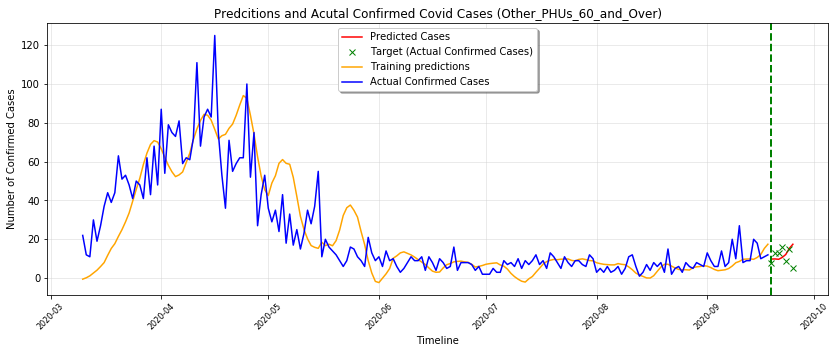

In [70]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-03-10'

plt.plot(PREDICTIONS_FUTURE_Other_PHUs_60_and_Over.index, PREDICTIONS_FUTURE_Other_PHUs_60_and_Over['result'], color='r', label='Predicted Cases')
plt.plot(dataset_base_test.index,dataset_base_test['Other_PHUs_60_and_Over'],'x', color='g', label='Target (Actual Confirmed Cases)')
plt.plot(PREDICTION_TRAIN_Other_PHUs_60_and_Over.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_Other_PHUs_60_and_Over.loc[START_DATE_FOR_PLOTTING:]['result'], color='orange', label='Training predictions')
plt.plot(dataset_base.loc[START_DATE_FOR_PLOTTING:].index, dataset_base.loc[START_DATE_FOR_PLOTTING:]['Other_PHUs_60_and_Over'], color='b', label='Actual Confirmed Cases')

plt.axvline(x = min(PREDICTIONS_FUTURE_Other_PHUs_60_and_Over.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Confirmed Covid Cases (Other_PHUs_60_and_Over)', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Number of Confirmed Cases', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

##### Step #3-5-5. Testing Accuracy of the Predictions

In [71]:
# Calcualte root mean square error between targets and predicted values.
targets_Other_PHUs_60_and_Over = dataset_base_test.Other_PHUs_60_and_Over.tolist()
predicted_Other_PHUs_60_and_Over = PREDICTIONS_FUTURE_Other_PHUs_60_and_Over.result.tolist()

rmse_Other_PHUs_60_and_Over = np.sqrt(mean_squared_error(targets_Other_PHUs_60_and_Over, predicted_Other_PHUs_60_and_Over))

print('Root mean square error between targets and predicted values == {}'.format(rmse_Other_PHUs_60_and_Over))

Root mean square error between targets and predicted values == 5.5812376584213315


##### Step #3-5-6. Predictions

In [72]:
# Present the 7 predicted days and the mean, median and stdev for them
print('Predicted values Other_PHUs_60_and_Over == {}'.format(predicted_Other_PHUs_60_and_Over))
print('Mean of predicted values Other_PHUs_60_and_Over == {}'.format(np.mean(np.array(predicted_Other_PHUs_60_and_Over))))
print('Median of predicted values Other_PHUs_60_and_Over == {}'.format(np.median(np.array(predicted_Other_PHUs_60_and_Over))))
print('Standard Deviation of predicted values Other_PHUs_60_and_Over == {}'.format(np.std(np.array(predicted_Other_PHUs_60_and_Over))))

Predicted values Other_PHUs_60_and_Over == [9.827068328857422, 9.88823127746582, 9.69483470916748, 10.63827133178711, 12.162710189819336, 15.320465087890625, 17.460037231445312]
Mean of predicted values Other_PHUs_60_and_Over == 12.1416597366333
Median of predicted values Other_PHUs_60_and_Over == 10.63827133178711
Standard Deviation of predicted values Other_PHUs_60_and_Over == 2.8553906006629277
